# WP1 - Anomaly Propagation Subgraph Extraction

In [4]:
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import networkx.algorithms.isomorphism as iso
import os

from anomaly_detection import detect_anomalies
import temporal_graph_generation as tgg
import correlation

In [5]:
reload(correlation)

<module 'correlation' from '/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/correlation.py'>

In [10]:
#manually load and import cloned overtime repository
os.getcwd()
os.chdir("../overtime")
import overtime
os.chdir("../src")

### 1. Read GraphML file for system graph with causality information

In [4]:
graph = nx.read_graphml("../data/causality_chi2.graphml")
graph = graph.to_undirected()
graph = nx.convert_node_labels_to_integers(graph)

/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id id. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id labels. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id causal. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/lisa/opt/anaconda3/envs/graphs_ml/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1032: UserWarning: No key type for id label. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")


### 2. Get and Add Anomaly Information for System Graph based on Domain Knowledge
anomaly is injected at ```frontend``` node with anomalies given on '2/17/2022' and '3/2/2022' 

In [5]:
full_data = pd.read_csv('../data/loadtest-timestamp.csv')
full_data[['Date', 'Time']] = full_data['Time'].str.split(" ", expand=True)
full_data = full_data.sort_values(by=['Date','Time'])
full_data.head()

,Unnamed: 0,Time,carts,carts-db,catalogue,catalogue-db,front-end,orders,orders-db,payment,queue-master,rabbitmq,session-db,shipping,user,user-db,Date
674,674,11:27,0.00245,0.00824,0.00129,0.00115,0.00313,0.00260,0.00901,0.00125,0.00254,0.0145,0.00232,0.00223,0.00178,0.00942,10/14/2021
675,675,11:28,0.00279,0.01020,0.00128,0.00108,0.00352,0.00273,0.00974,0.00131,0.00249,0.0136,0.00268,0.00235,0.00191,0.01060,10/14/2021
676,676,11:29,0.00345,0.00929,0.00140,0.00118,0.00379,0.00262,0.00938,0.00137,0.00329,0.0132,0.00260,0.00214,0.00198,0.01020,10/14/2021
677,677,11:30,0.00233,0.00890,0.00108,0.00112,0.00343,0.00227,0.00783,0.00130,0.00239,0.0113,0.00223,0.00221,0.00173,0.00869,10/14/2021
678,678,11:31,0.00421,0.00914,0.00148,0.00138,0.00405,0.00297,0.00980,0.00141,0.00250,0.0127,0.00259,0.00234,0.00233,0.01030,10/14/2021


In [11]:
#error at data node is expected (not enough information given)
detect_anomalies(full_data, graph, ['2/17/2022', '3/2/2022'], ['10/14/2021', '10/19/2021', '10/20/2021'])

Node names from data csv:  ['carts', 'carts-db', 'catalogue', 'catalogue-db', 'front-end', 'orders', 'orders-db', 'payment', 'queue-master', 'rabbitmq', 'session-db', 'shipping', 'user', 'user-db']
Node names from graph:  ['carts', 'carts-db', 'catalogue', 'catalogue-db', 'front-end', 'master', 'orders', 'orders-db', 'payment', 'queue-master', 'rabbitmq', 'session-db', 'shipping', 'user', 'user-db', 'worker1', 'worker2']
Nodes in graph but not in data csv:  ['master', 'worker1', 'worker2']
Nodes in data csv but not in graph:  []


100%|██████████| 589/589 [00:00<00:00, 2960.05it/s]


Traceback (most recent call last):
  File "/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/anomaly_detection.py", line 28, in detect_anomalies
    s.initialize(verbose=False) 		# initialization step
  File "/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/spot.py", line 199, in initialize
    g,s,l = self._grimshaw()
  File "/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/spot.py", line 345, in _grimshaw
    right_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
  File "/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/spot.py", line 238, in _rootsFinder
    X0 = np.arange(bounds[0]+step,bounds[1],step)
ValueError: arange: cannot compute length



/Users/lisa/Documents/GitHub/Spatio-Temporal-Graphs/src/spot.py:238: RuntimeWarning: invalid value encountered in double_scalars
  X0 = np.arange(bounds[0]+step,bounds[1],step)


In [12]:
#only keep causal edges in graph for anomaly propagation subgraph extraction
remove_edges = [e for e in graph.edges(data=True) if e[2].get('causal')!='true']
graph.remove_edges_from(remove_edges) #inplace

### 3. Sample APG subgraphs with dfs/bfs tree combination

In [14]:
MAXLAG = 2
DATETIME_FORMAT = "%m/%d/%Y %H:%M"

frontend_node = [n for n in graph.nodes.data() if n[1]["id"] == "front-end"][0]

3.1. Check subgraph that can be extracted based on real anomaly timestamps in system graph

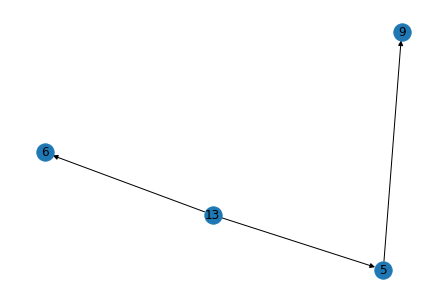

In [16]:
tg= tgg.sample_subgraph_with_timestamp_constraint(graph, frontend_node[0], bfs_prob=0.5, random_seed=111, start_timestamp='3/2/2022 13:22', datetime_format=DATETIME_FORMAT, maxlag=MAXLAG)
nx.draw(tg, with_labels=True)

3.2. Sample all possible temporal subgraphs from system graph between 2 and maximum amount of nodes with all possible temporal combinations

In [ ]:
tn_subgraphs = tgg.sample_temporal_subgraphs(graph, frontend_node[0])

In [ ]:
np.save('../data/apg_unique_subgraphs_temporal_node2-17.npy', correlation.encode_temporal_graphs(tn_subgraphs))

In [ ]:
len(tn_subgraphs)

Sample visualizations of temporal subgraphs

In [6]:
read_apg = correlation.decode_temporal_graphs(np.load('../data/apg_unique_subgraphs_temporal_node2-17.npy'))

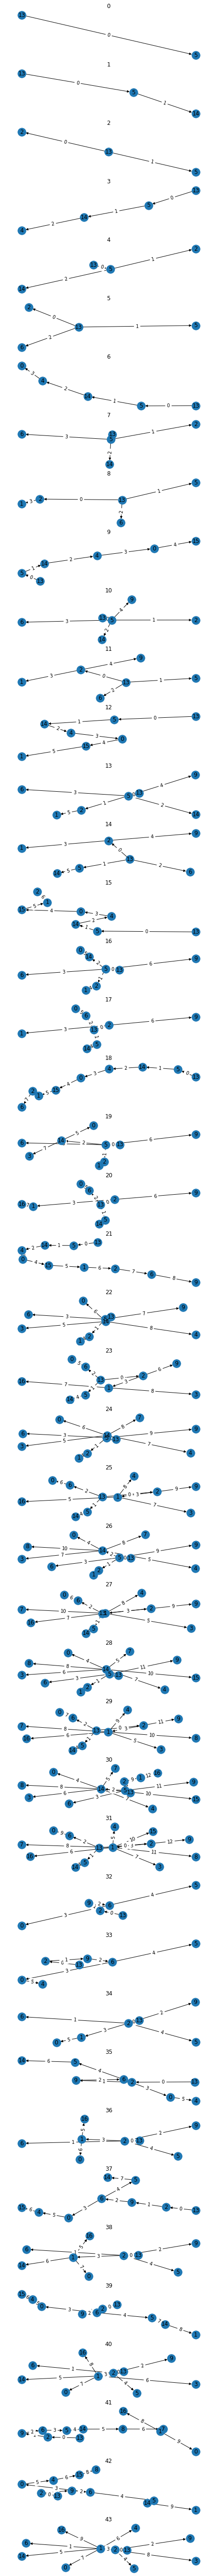

In [13]:
fig, axes = plt.subplots(44, 1, figsize=(8,100))
for i, subgraph in enumerate(read_apg[:44]):
    nx.draw(subgraph, nx.spring_layout(subgraph, seed=7), with_labels=True, ax=axes[i])
    axes[i].set_title(i)
    edge_labels = nx.get_edge_attributes(subgraph, "timestep")
    nx.draw_networkx_edge_labels(subgraph, nx.spring_layout(subgraph, seed=7), edge_labels, ax=axes[i])

In [7]:
subgraph_nodes = [len(sg.nodes) for sg in read_apg]

(array([3.000e+00, 3.000e+00, 9.000e+00, 2.900e+01, 1.010e+02, 1.117e+03,
        1.224e+03, 1.456e+03, 1.636e+03, 3.750e+03]),
 array([ 2. ,  3.2,  4.4,  5.6,  6.8,  8. ,  9.2, 10.4, 11.6, 12.8, 14. ]),
 <BarContainer object of 10 artists>)

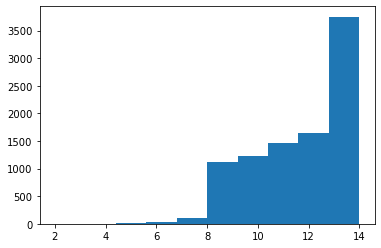

In [8]:
plt.hist(subgraph_nodes)

(array([3.000e+00, 3.000e+00, 9.000e+00, 2.900e+01, 1.010e+02, 1.117e+03,
        1.224e+03, 1.456e+03, 1.636e+03, 3.750e+03]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <BarContainer object of 10 artists>)

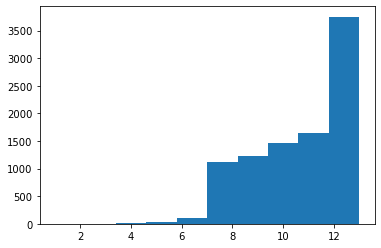

In [9]:
subgraph_sizes = [sg.size() for sg in read_apg]
plt.hist(subgraph_sizes)

Text(0, 0.5, '# of Nodes')

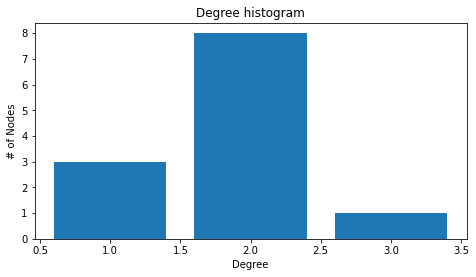

In [59]:
degree_sequence = sorted((d for n, d in read_apg[45].degree()), reverse=True)
fig = plt.figure("Degree of a random graph", figsize=(6, 3))
ax = fig.add_axes([0,0,1,1])
ax.bar(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Degree histogram")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")

### Test temporal centralities with teneto package

In [ ]:
edge_df = nx.to_pandas_edgelist(subgraph)
edge_df.columns = ['i','j','t']
edge_df = edge_df.replace(to_replace=r'^n', value='', regex=True)
edge_df = edge_df.apply(pd.to_numeric)
edge_df

In [ ]:
add_edges = []
max_time = np.max(edge_df['t'])
for i in edge_df.index:
    row = edge_df.iloc[i]
    times_to_add = np.arange(row["t"], max_time+1)
    for t_to_add in times_to_add:
        add_edges.append([row["i"], row["j"], t_to_add])

In [ ]:
fill_edges = pd.DataFrame(add_edges, columns=edge_df.columns)
fill_edges

In [ ]:
import teneto

tnet = teneto.TemporalNetwork(from_df=fill_edges)

In [ ]:
closeness_centrality =  teneto.networkmeasures.temporal_closeness_centrality(tnet=tnet)

In [ ]:
#degree centrality
pd.Series(teneto.networkmeasures.temporal_degree_centrality(tnet=tnet))

In [ ]:
betweenness_centrality =  teneto.networkmeasures.temporal_betweenness_centrality(tnet=tnet)
betweenness_centrality

### Test temporal centralities with overtime package

In [14]:
subgraph = read_apg[1] # example subgraph
edge_df = nx.to_pandas_edgelist(subgraph)
max_time = np.max(edge_df['timestep'])

temporal_network = overtime.TemporalDiGraph("test_network")
for node in subgraph.nodes():
    temporal_network.add_node(node)
for _, edge in edge_df.iterrows():
    temporal_network.add_edge(str(edge["source"]), str(edge["target"]), edge["timestep"] + 1, max_time + 2)

In [15]:
edge_df

,source,target,timestep
0,13,5,0
1,5,14,1


In [16]:
tc_fastest = overtime.temporal_betweenness(temporal_network, optimality="shortest")
tc_fastest

{'14': 0, '13': 0.0, '5': 1.0}

In [ ]:
#plot temporal graph with centrality attributes via overtime visualization methods
labels = []
for t in range(temporal_network.edges.start(), temporal_network.edges.end()):
    print(t)
    figure, axes = plt.subplots(1)
    labels.append('examples/time_' + str(t) + '.png')
    print(temporal_network.get_snapshot(t))
    overtime.plots.circle.Circle(temporal_network.get_snapshot(t), axes)

### Calculate temporal centrality vectors for list of graphs

In [39]:
temporal_closeness_vectors_t = []
temporal_betweenness_vectors_t = []
temporal_degree_vectors_t = []

for s in read_apg:
    edge_df = nx.to_pandas_edgelist(s)
    max_time = np.max(edge_df['timestep'])

    temporal_network = overtime.TemporalDiGraph("test_network")
    for node in s.nodes():
        temporal_network.add_node(node)
    for _, edge in edge_df.iterrows():
        temporal_network.add_edge(str(edge["source"]), str(edge["target"]), edge["timestep"] + 1, max_time + 2)
    
    closeness_centrality =  overtime.temporal_closeness(temporal_network, optimality="fastest")
    temporal_closeness_vectors_t.append(closeness_centrality)
    betweenness_centrality = overtime.temporal_betweenness(temporal_network, optimality="foremost")
    temporal_betweenness_vectors_t.append(betweenness_centrality)
    degree_centrality = overtime.temporal_degree(temporal_network, in_out='out') #out-degree centrality
    temporal_degree_vectors_t.append(degree_centrality)

In [40]:
print(temporal_closeness_vectors_t[8])
print(temporal_closeness_vectors_t[13])
print(temporal_closeness_vectors_t[16])

{'2': 1.0, '6': 0.0, '5': 0.0, '13': 1.3333333333333333, '1': 0.0}
{'14': 0.0, '9': 0.0, '2': 1.0, '6': 0.0, '13': 0.9999999999999999, '5': 1.4833333333333332, '1': 0.0}
{'6': 0.0, '2': 0.3333333333333333, '5': 1.9833333333333334, '14': 0.5, '0': 0.0, '1': 0.0, '13': 0.9999999999999998, '9': 0.0}


In [41]:
print(temporal_betweenness_vectors_t[8])
print(temporal_betweenness_vectors_t[13])
print(temporal_betweenness_vectors_t[16])

{'2': 1.0, '6': 0, '5': 0, '13': 0.0, '1': 0}
{'14': 0, '9': 0, '2': 2.0, '6': 0, '13': 0.0, '5': 5.0, '1': 0}
{'6': 0, '2': 2.0, '5': 6.0, '14': 2.0, '0': 0, '1': 0, '13': 0.0, '9': 0}


In [47]:
temporal_degree_vectors_t[:5]

[{'13': 1.0, '5': 0.0},
 {'13': 0.5, '5': 0.5, '14': 0.0},
 {'5': 0.0, '13': 1.0, '2': 0.0},
 {'4': 0.0,
  '13': 0.3333333333333333,
  '14': 0.3333333333333333,
  '5': 0.3333333333333333},
 {'2': 0.0, '13': 0.3333333333333333, '14': 0.0, '5': 0.6666666666666666}]

In [42]:
np.save('../data/temporal_betweenness_vectors_overtime.npy',temporal_betweenness_vectors_t)

In [43]:
np.save('../data/temporal_closeness_vectors_overtime.npy',temporal_closeness_vectors_t)

In [44]:
np.save('../data/temporal_degree_vectors_overtime.npy', temporal_degree_vectors_t)